In [1]:
import random
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
class player(object):
    """
    player() class
    
    Class defining a player object that stores position, velocity, time-to-intercept and pitch control contributions for a player
    
    __init__ Parameters
    -----------
    pid: id (jersey number) of player
    team: row of tracking data for team
    teamname: team name "Home" or "Away"
    params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
    
    methods include:
    -----------
    simple_time_to_intercept(r_final): time take for player to get to target position (r_final) given current position
    probability_intercept_ball(T): probability player will have controlled football at time T given their expected time_to_intercept
    
    """
    # player object holds position, velocity, time-to-intercept and pitch control contributions for each player
    def __init__(self,pid,team,teamname,params):
        self.id = pid
        self.teamname = teamname
        self.playername = "%s_%s_" % (teamname,pid)
        self.vmax = params['max_player_speed'] # player max speed in m/s. Could be individualised
        self.reaction_time = 0.4 #params['reaction_time'] # player reaction time in 's'. Could be individualised
        self.tti_sigma = params['tti_sigma'] # standard deviation of sigmoid function (see Eq 4 in Spearman, 2018)
        self.lambda_att = params['lambda_att'] # standard deviation of sigmoid function (see Eq 4 in Spearman, 2018)
        self.lambda_def = params['lambda_def'] # factor of 3 ensures that anything near the GK is likely to be claimed by the GK
        self.get_position(team)
        self.get_velocity(team)
        self.PPCF = 0. # initialise this for later
        
    def get_position(self,team):
        self.position = np.array( [ team[self.playername+'x'], team[self.playername+'y'] ] )
        self.inframe = not np.any( np.isnan(self.position) )
        
    def get_velocity(self,team):
        self.velocity = np.array( [ team[self.playername+'vx'], team[self.playername+'vy'] ] )
        if np.any( np.isnan(self.velocity) ):
            self.velocity = np.array([0.,0.])
    
    def simple_time_to_intercept(self, r_final):
        self.PPCF = 0. # initialise this for later
        # Time to intercept assumes that the player continues moving at current velocity for 'reaction_time' seconds
        # and then runs at full speed to the target position.
        r_reaction = self.position + self.velocity*self.reaction_time
        self.time_to_intercept = self.reaction_time + np.linalg.norm(r_final-r_reaction)/self.vmax
        return self.time_to_intercept

    def probability_intercept_ball(self,T):
        # probability of a player arriving at target location at time 'T' given their expected time_to_intercept (time of arrival), as described in Spearman 2018
        f = 1/(1. + np.exp( -np.pi/np.sqrt(3.0)/self.tti_sigma * (T-self.time_to_intercept) ) )
        return f

In [3]:
def initialise_players(team,teamname,params):
    """
    initialise_players(team,teamname,params)
    
    create a list of player objects that holds their positions and velocities from the tracking data dataframe 
    
    Parameters
    -----------
    
    team: row (i.e. instant) of either the home or away team tracking Dataframe
    teamname: team name "Home" or "Away"
    params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        
    Returns
    -----------
    
    team_players: list of player objects for the team at at given instant
    
    """    
    # get player  ids
    player_ids = np.unique( [ c.split('_')[1] for c in team.keys() if c[:len(teamname)] == teamname ] )
    print("Player IDs:", player_ids)  # Check if player IDs are correctly extracted
    # create list
    team_players = []
    for p in player_ids:
        # create a player object for player_id 'p'
        team_player = player(p,team,teamname,params)
        team_players.append(team_player)
        print("Player Object:", team_player)  # Check the created player object
    return team_players

In [4]:
def default_model_params(time_to_control_veto=3):
    """
    default_model_params()
    
    Returns the default parameters that define and evaluate the model. See Spearman 2018 for more details.
    
    Parameters
    -----------
    time_to_control_veto: If the probability that another team or player can get to the ball and control it is less than 10^-time_to_control_veto, ignore that player.
    
    
    Returns
    -----------
    
    params: dictionary of parameters required to determine and calculate the model
    
    """
    # key parameters for the model, as described in Spearman 2018
    params = {}
    # model parameters
    params['max_player_accel'] = 7. # maximum player acceleration y/s/s, not used in this implementation
    params['max_player_speed'] = 9.7 # maximum player speed y/s
    params['reaction_time'] = 0.7 # seconds, time taken for player to react and change trajectory. Roughly determined as vmax/amax
    params['tti_sigma'] = 0.45 # Standard deviation of sigmoid function in Spearman 2018 ('s') that determines uncertainty in player arrival time
    params['kappa_def'] =  1. # kappa parameter in Spearman 2018 (=1.72 in the paper) that gives the advantage defending players to control ball, I have set to 1 so that home & away players have same ball control probability
    params['lambda_att'] = 4.3 # ball control parameter for attacking team
    params['lambda_def'] = 4.3 * params['kappa_def'] # ball control parameter for defending team
    params['average_ball_speed'] = 15. # average ball travel speed in m/s
    # numerical parameters for model evaluation
    params['int_dt'] = 0.04 # integration timestep (dt)
    params['max_int_time'] = 10 # upper limit on integral time
    params['model_converge_tol'] = 0.10 # assume convergence when PPCF>0.99 at a given location.
    # The following are 'short-cut' parameters. We do not need to calculated PPCF explicitly when a player has a sufficient head start. 
    # A sufficient head start is when the a player arrives at the target location at least 'time_to_control' seconds before the next player
    params['time_to_control_att'] = time_to_control_veto*np.log(10) * (np.sqrt(3)*params['tti_sigma']/np.pi + 1/params['lambda_att'])
    params['time_to_control_def'] = time_to_control_veto*np.log(10) * (np.sqrt(3)*params['tti_sigma']/np.pi + 1/params['lambda_def'])
    return params

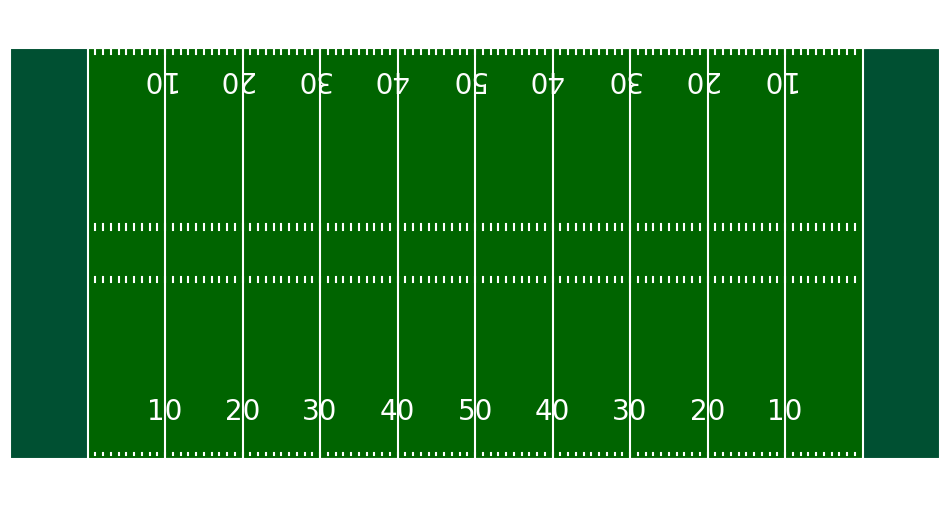

In [5]:
def plot_pitch(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,                         
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                     numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

plot_pitch()
plt.show()

In [6]:
def build_grid(n_grid_cells_x):
    """Build a grid based on pitch dimensions and number of x cells passed.
    
    Parameters
    ----------
    n_grid_cells_x: int
        Number of cells per row in the x direction
    
    Returns
    -------
    tuple(Pitch Control for attacking team, defending team, xgrid, ygrid)
    
    """
    field_dimen=[120,53.3]
    n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
    dx = field_dimen[0]/n_grid_cells_x
    dy = field_dimen[1]/n_grid_cells_y
    xgrid = np.arange(n_grid_cells_x)*dx - field_dimen[0]/2 + dx/2. +60
    ygrid = np.arange(n_grid_cells_y)*dy - field_dimen[1]/2 + dy/2. +26.65
    # initialise pitch control grids for attacking/defending team
    PPCFa = np.zeros( shape = (len(ygrid), len(xgrid)) )
    PPCFd = np.zeros( shape = (len(ygrid), len(xgrid)) )
    return PPCFa, PPCFd , xgrid, ygrid

In [7]:
x_cells = 120
PPCFa, PPCFd, xgrid, ygrid = build_grid(x_cells)

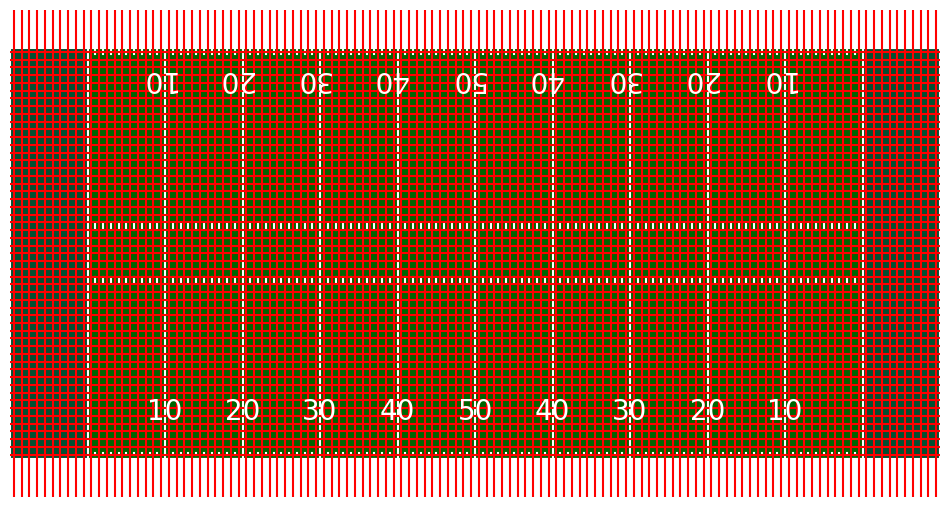

In [8]:
fig,ax = plot_pitch()
for y_line in ygrid:
    plt.axhline(y=y_line, color='r', linestyle='-')
for x_line in xgrid:
    plt.axvline(x=x_line, color='r', linestyle='-')

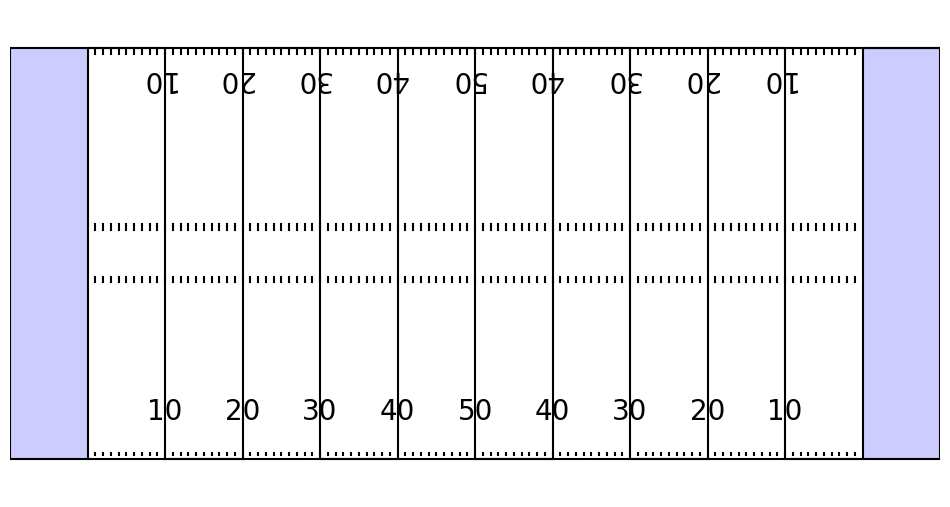

In [9]:
def plot_white_pitch(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='white', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='black')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,                         
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                     numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='black')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='black', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='black')
        ax.plot([x, x], [53.0, 52.5], color='black')
        ax.plot([x, x], [22.91, 23.57], color='black')
        ax.plot([x, x], [29.73, 30.39], color='black')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

plot_white_pitch()
plt.show()

In [10]:
def plot_frame( hometeam, awayteam, figax=None, team_colors=('r','b'), field_dimen = (120,53.3), include_player_velocities=False, PlayerMarkerSize=10, PlayerAlpha=0.7, annotate=False ):
    """ plot_frame( hometeam, awayteam )
    
    Plots a frame of Metrica tracking data (player positions and the ball) on a football pitch. All distances should be in meters.
    
    Parameters
    -----------
        hometeam: row (i.e. instant) of the home team tracking data frame
        awayteam: row of the away team tracking data frame
        fig,ax: Can be used to pass in the (fig,ax) objects of a previously generated pitch. Set to (fig,ax) to use an existing figure, or None (the default) to generate a new pitch plot, 
        team_colors: Tuple containing the team colors of the home & away team. Default is 'r' (red, home team) and 'b' (blue away team)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
        PlayerMarkerSize: size of the individual player marlers. Default is 10
        PlayerAlpha: alpha (transparency) of player markers. Defaault is 0.7
        annotate: Boolean variable that determines with player jersey numbers are added to the plot (default is False)
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

    """
    if figax is None: # create new pitch 
        fig,ax = plot_pitch()
    else: # overlay on a previously generated pitch
        fig,ax = figax # unpack tuple
    # plot home & away teams in order
    for team,color in zip( [hometeam,awayteam], team_colors) :
        x_columns = [c for c in team.keys() if c[-2:].lower()=='_x'] # column header for player x positions
        y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' ] # column header for player y positions
        ax.plot(team[x_columns], team[y_columns], color+'o', markersize=PlayerMarkerSize, alpha=PlayerAlpha,markeredgecolor = 'black')
        if include_player_velocities:
            
            vx_columns = ['{}_vx'.format(c[:-2]) for c in x_columns] # column header for player x positions
            vy_columns = ['{}_vy'.format(c[:-2]) for c in y_columns] # column header for player y positions
            
            team[x_columns]= team[x_columns].astype(float)
            team[y_columns]= team[y_columns].astype(float)
            team[vx_columns]= team[vx_columns].astype(float)
            team[vy_columns]= team[vy_columns].astype(float)
            ax.quiver( team[x_columns], team[y_columns], team[vx_columns], team[vy_columns], color=color, scale_units='inches', scale=10.,width=0.0015,headlength=5,headwidth=3,alpha=PlayerAlpha)
        if annotate:
            [ ax.text( team[x]+0.5, team[y]+0.5, x.split('_')[1], fontsize=10, color='black'  ) for x,y in zip(x_columns,y_columns) if not ( np.isnan(team[x]) or np.isnan(team[y]) ) ] 
    return fig,ax

In [11]:
df = pd.read_csv("C:/Users/TheRe/Downloads/TrackingData/tracking_week_1.csv")

In [12]:
df2 = df.loc[df["gameId"]==2022090800]
df2=df2[["playId","club","frameId","time","jerseyNumber","x","y","s","dir"]]
# I don't want floats as jerseys, but there's also NaN's in there which is the ball. So temporariryl set the ball to 
# 9999999, convert everything to an int, then a string. Then change the 9999999 back to a ball.
df2["jerseyNumber"] = df2["jerseyNumber"].fillna(9999999).astype(int).astype(str)
df2["jerseyNumber"]=df2["jerseyNumber"].replace("9999999","ball")
# Add the club to the jersey
df2["jerseyNumber"]=+df2["club"]+"_"+df2["jerseyNumber"]
# Convert 'dir' to an integer
df2['dir'] = pd.to_numeric(df2['dir'], errors='coerce')
df2['s'] = pd.to_numeric(df2['s'], errors='coerce')
# Perform the arithmetic operation
df2['angle'] = 360 + (90-df['dir'])
cos_values = df2['angle'].apply(lambda x: math.cos(x * 2 * math.pi / 360))
sin_values = df2['angle'].apply(lambda x: math.sin(x * 2 * math.pi / 360))

# Multiply the trigonometric values with the string 's' (converted to string)
df2['vx'] =  (cos_values * df2['s']).astype(float)
df2['vy'] =  (sin_values * df2['s']).astype(float)
df2

,playId,club,frameId,time,jerseyNumber,x,y,s,dir,angle,vx,vy
0,56,BUF,1,2022-09-08 20:24:05.200000,BUF_76,88.370000,27.270000,1.62,147.90,302.10,0.860866,-1.372338
1,56,BUF,2,2022-09-08 20:24:05.299999,BUF_76,88.470000,27.130000,1.67,148.53,301.47,0.871827,-1.424366
2,56,BUF,3,2022-09-08 20:24:05.400000,BUF_76,88.560000,27.010000,1.57,147.05,302.95,0.853934,-1.317458
3,56,BUF,4,2022-09-08 20:24:05.500000,BUF_76,88.640000,26.900000,1.44,145.42,304.58,0.817281,-1.185602
4,56,BUF,5,2022-09-08 20:24:05.599999,BUF_76,88.720000,26.800000,1.29,141.95,308.05,0.795090,-1.015840
...,...,...,...,...,...,...,...,...,...,...,...,...
79207,3636,football,36,2022-09-08 23:05:27.099999,football_ball,26.309999,28.690001,1.55,NaN,NaN,NaN,NaN
79208,3636,football,37,2022-09-08 23:05:27.200000,football_ball,26.209999,28.799999,1.23,NaN,NaN,NaN,NaN
79209,3636,football,38,2022-09-08 23:05:27.299999,football_ball,26.160000,28.959999,1.03,NaN,NaN,NaN,NaN
79210,3636,football,39,2022-09-08 23:05:27.400000,football_ball,26.139999,29.190001,0.95,NaN,NaN,NaN,NaN


In [13]:
# Pivot the table
df_pivot = df2.pivot_table(index=['playId','frameId', 'time'], columns='jerseyNumber', values=['x', 'y','vx','vy','s'])
# Flatten the multi-level column structure and create new column names
df_pivot.columns = [f'{str(col[1])}_{col[0]}' for col in df_pivot.columns.values]
# Reset the index to turn multi-index into columns
df_pivot.reset_index(inplace=True)
# Resulting dataframe.
df_pivot.head()

,playId,frameId,time,BUF_13_s,BUF_14_s,BUF_15_s,BUF_17_s,BUF_20_s,BUF_21_s,BUF_23_s,...,LA_88_y,LA_89_y,LA_9_y,LA_91_y,LA_92_y,LA_93_y,LA_94_y,LA_96_y,LA_99_y,football_ball_y
0,56,1,2022-09-08 20:24:05.200000,7.91,6.23,NaN,0.29,NaN,NaN,NaN,...,NaN,NaN,NaN,28.50,NaN,NaN,25.47,NaN,31.61,33.810001
1,56,2,2022-09-08 20:24:05.299999,7.97,6.24,NaN,0.11,NaN,NaN,NaN,...,NaN,NaN,NaN,28.69,NaN,NaN,25.54,NaN,31.32,34.830002
2,56,3,2022-09-08 20:24:05.400000,7.94,5.98,NaN,0.05,NaN,NaN,NaN,...,NaN,NaN,NaN,28.90,NaN,NaN,25.59,NaN,30.98,35.590000
3,56,4,2022-09-08 20:24:05.500000,7.91,5.67,NaN,0.12,NaN,NaN,NaN,...,NaN,NaN,NaN,29.14,NaN,NaN,25.63,NaN,30.65,36.450001
4,56,5,2022-09-08 20:24:05.599999,7.91,5.43,NaN,0.18,NaN,NaN,NaN,...,NaN,NaN,NaN,29.38,NaN,NaN,25.65,NaN,30.30,36.930000


In [14]:
# Parse the column names to extract the jersey number and coordinate
parsed_columns = [(int(col.split('_')[1]), col.split('_')[2], col) for col in df_pivot.columns if '_' in col and not "ball" in col]
# Sort by jersey number, then by coordinate (x before y)
sorted_columns = sorted(parsed_columns, key=lambda x: (x[0], x[1]))
# Extract the original column names from the sorted tuples
sorted_col_names = [col[2] for col in sorted_columns]
final_df = df_pivot[["playId","frameId","time"]+sorted_col_names]

# Display the first few rows of the rearranged dataframe
final_df.head()

,playId,frameId,time,LA_1_s,LA_1_vx,LA_1_vy,LA_1_x,LA_1_y,LA_2_s,LA_2_vx,...,BUF_99_s,LA_99_s,BUF_99_vx,LA_99_vx,BUF_99_vy,LA_99_vy,BUF_99_x,LA_99_x,BUF_99_y,LA_99_y
0,56,1,2022-09-08 20:24:05.200000,NaN,NaN,NaN,NaN,NaN,4.36,-4.252156,...,NaN,3.91,NaN,2.904783,NaN,-2.617315,NaN,91.08,NaN,31.61
1,56,2,2022-09-08 20:24:05.299999,NaN,NaN,NaN,NaN,NaN,4.12,-4.043202,...,NaN,3.93,NaN,2.716159,NaN,-2.840313,NaN,91.36,NaN,31.32
2,56,3,2022-09-08 20:24:05.400000,NaN,NaN,NaN,NaN,NaN,3.83,-3.783368,...,NaN,3.99,NaN,2.466355,NaN,-3.136430,NaN,91.62,NaN,30.98
3,56,4,2022-09-08 20:24:05.500000,NaN,NaN,NaN,NaN,NaN,3.50,-3.479791,...,NaN,3.93,NaN,2.149627,NaN,-3.289985,NaN,91.83,NaN,30.65
4,56,5,2022-09-08 20:24:05.599999,NaN,NaN,NaN,NaN,NaN,2.99,-2.989242,...,NaN,3.82,NaN,1.802793,NaN,-3.367839,NaN,92.01,NaN,30.30


In [15]:
#Label and split the dataset into their respective teams
la_columns = [col for col in final_df.columns if col.startswith('LA_')]
buf_columns = [col for col in final_df.columns if col.startswith('BUF_')]
tracking_home= final_df[['playId','frameId', 'time'] + la_columns].copy()
tracking_away  = final_df[['playId','frameId', 'time'] + buf_columns].copy()
tracking_home['teamname'] = 'Home'
tracking_away ['teamname'] = 'Away'
tracking_home

,playId,frameId,time,LA_1_s,LA_1_vx,LA_1_vy,LA_1_x,LA_1_y,LA_2_s,LA_2_vx,...,LA_96_vx,LA_96_vy,LA_96_x,LA_96_y,LA_99_s,LA_99_vx,LA_99_vy,LA_99_x,LA_99_y,teamname
0,56,1,2022-09-08 20:24:05.200000,NaN,NaN,NaN,NaN,NaN,4.36,-4.252156,...,NaN,NaN,NaN,NaN,3.91,2.904783,-2.617315,91.08,31.61,Home
1,56,2,2022-09-08 20:24:05.299999,NaN,NaN,NaN,NaN,NaN,4.12,-4.043202,...,NaN,NaN,NaN,NaN,3.93,2.716159,-2.840313,91.36,31.32,Home
2,56,3,2022-09-08 20:24:05.400000,NaN,NaN,NaN,NaN,NaN,3.83,-3.783368,...,NaN,NaN,NaN,NaN,3.99,2.466355,-3.136430,91.62,30.98,Home
3,56,4,2022-09-08 20:24:05.500000,NaN,NaN,NaN,NaN,NaN,3.50,-3.479791,...,NaN,NaN,NaN,NaN,3.93,2.149627,-3.289985,91.83,30.65,Home
4,56,5,2022-09-08 20:24:05.599999,NaN,NaN,NaN,NaN,NaN,2.99,-2.989242,...,NaN,NaN,NaN,NaN,3.82,1.802793,-3.367839,92.01,30.30,Home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3441,3636,36,2022-09-08 23:05:27.099999,3.02,-2.056549,-2.211562,23.47,32.65,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Home
3442,3636,37,2022-09-08 23:05:27.200000,2.79,-1.899568,-2.043463,23.28,32.44,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Home
3443,3636,38,2022-09-08 23:05:27.299999,2.48,-1.738255,-1.768861,23.09,32.25,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Home
3444,3636,39,2022-09-08 23:05:27.400000,2.16,-1.583575,-1.468976,22.93,32.09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Home


In [16]:
params = params =default_model_params()

In [17]:
frame_of_interest =0
attacking_players = initialise_players(tracking_home.loc[frame_of_interest],'LA', params)
defending_players = initialise_players(tracking_away.loc[frame_of_interest],'BUF', params)

Player IDs: ['1' '10' '15' '18' '19' '2' '22' '24' '27' '3' '33' '4' '45' '5' '52'
 '53' '54' '55' '58' '65' '70' '73' '79' '88' '89' '9' '91' '92' '93' '94'
 '96' '99']
Player Object: <__main__.player object at 0x00000238627C5D90>
Player Object: <__main__.player object at 0x000002386220E390>
Player Object: <__main__.player object at 0x000002386279F010>
Player Object: <__main__.player object at 0x00000238616D4150>
Player Object: <__main__.player object at 0x0000023801E832D0>
Player Object: <__main__.player object at 0x0000023801E80550>
Player Object: <__main__.player object at 0x0000023801E838D0>
Player Object: <__main__.player object at 0x0000023801E809D0>
Player Object: <__main__.player object at 0x0000023801E81A90>
Player Object: <__main__.player object at 0x0000023801E80710>
Player Object: <__main__.player object at 0x0000023801E801D0>
Player Object: <__main__.player object at 0x0000023801E80750>
Player Object: <__main__.player object at 0x0000023801E83110>
Player Object: <__main__

In [18]:
def pitch_control_function(target_position, attacking_players, defending_players):
    """A naive pitch control function - whomever is closest to target area claims ownership."""
        
    def distance_to_target(player):
        distance = np.linalg.norm(player-target_position)
        return distance
        
        
    min_distance_attacking_team = np.nanmin( [distance_to_target(p.position) for p in attacking_players] )
    min_distance_defending_team = np.nanmin( [distance_to_target(p.position) for p in defending_players] )
    
    if min_distance_attacking_team <= min_distance_defending_team:
        return 1
    else:
        return 0
      

In [19]:
def plot_pitch_control(pitch_control_matrix,frame_of_interest_attacking_team, frame_of_interest,interpolation="spline36"):
    field_dimen=[120,53.3]
    fig, ax= plot_white_pitch()
    # plot pitch control surface
    if frame_of_interest_attacking_team=='LA':
        cmap = 'bwr_r'
    else:
        cmap = 'bwr'
    plot_frame( tracking_home.loc[frame_of_interest], tracking_away.loc[frame_of_interest], figax=(fig,ax), PlayerAlpha=0.8, include_player_velocities=False, annotate=True )
    # For options see https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html
    ax.imshow(pitch_control_matrix, extent=(0, field_dimen[0],0, field_dimen[1]), interpolation=interpolation, vmin=0, vmax=1, cmap=cmap, alpha=0.38, origin='lower')
    return fig, ax

In [20]:
for i in range( len(ygrid) ):
    for j in range( len(xgrid) ):
        target_position = np.array( [xgrid[j], ygrid[i]] )
        PPCFa[i,j] = pitch_control_function(target_position, attacking_players, defending_players)

Text(0.5, 0.01, 'Movement Model based off distance from each player to each individual square. Whichever team has the minimum distance to that square is given ownership and that square is assigned their value. Red and blue indicate the LA Rams and Buffalo Bills respectively.')

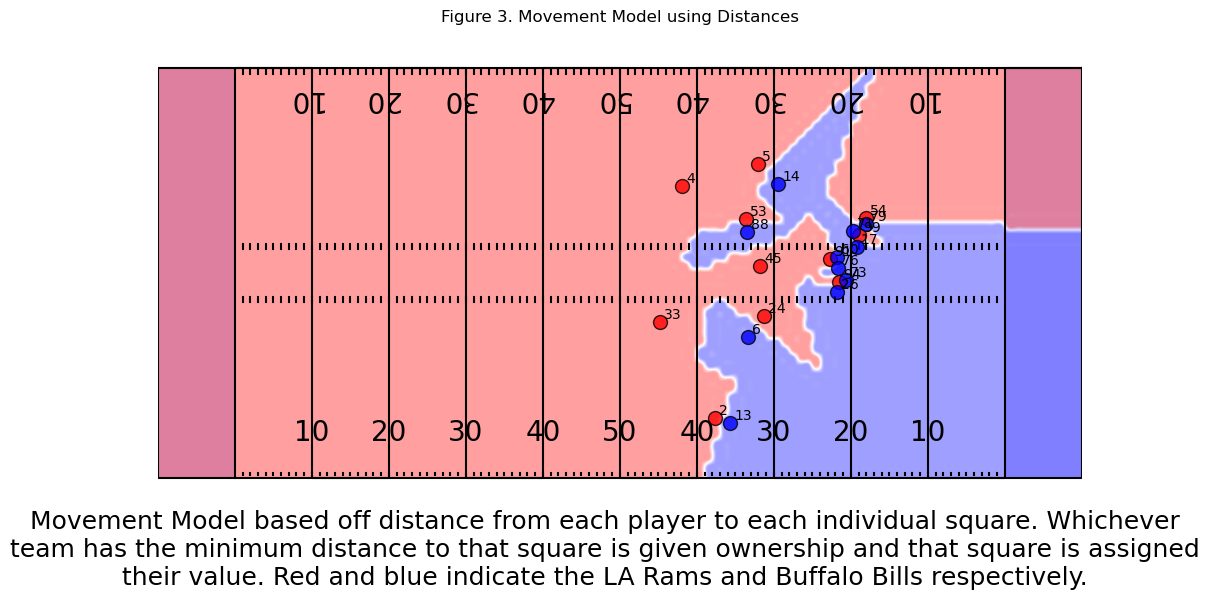

In [21]:
plot_pitch_control(PPCFa,attacking_players,0,interpolation="spline36")
plt.title('Figure 3. Movement Model using Distances')
caption = "Movement Model based off distance from each player to each individual square. Whichever team has the minimum distance to that square is given ownership and that square is assigned their value. Red and blue indicate the LA Rams and Buffalo Bills respectively."
plt.figtext(0.5,0.01,caption,wrap = True, horizontalalignment = 'center', fontsize = '18')

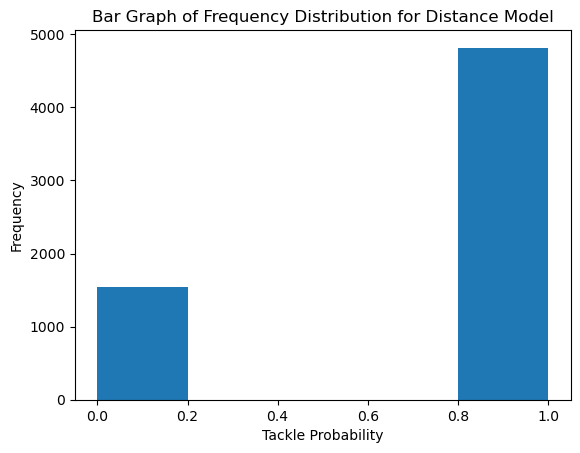

In [22]:
flattened_values = PPCFa.flatten()

# Define the bins (x-axis range)
bins = np.arange(0, 1.2, 0.2)

# Compute the histogram
hist, edges = np.histogram(flattened_values, bins=bins)

# Plotting the histogram as a bar graph
plt.bar(edges[:-1], hist, width=0.2, align='edge')

plt.xlabel('Tackle Probability')
plt.ylabel('Frequency')
plt.title('Bar Graph of Frequency Distribution for Distance Model')
plt.show()

In [23]:
def pitch_control_function_velocity(target_position, attacking_players, defending_players):
    """A naive pitch control function - whomever get's to target area first - based solely on velocity - claims ownership."""
        
    min_time_attacking_team = np.nanmin( [p.simple_time_to_intercept(target_position) for p in attacking_players] )
    min_time_defending_team = np.nanmin( [p.simple_time_to_intercept(target_position) for p in defending_players] )

    if min_time_attacking_team <= min_time_defending_team:
        return 1
    else:
        return 0


In [24]:
for i in range( len(ygrid) ):
    for j in range( len(xgrid) ):
        target_position = np.array( [xgrid[j], ygrid[i]] )
        PPCFa[i,j] = pitch_control_function_velocity(target_position, attacking_players, defending_players)

Text(0.5, 0.01, 'Movement Model based off time it takes each player to reach each individual square given their position and velocity. Whichever team has the minimum time to that square is given ownership and that square is assigned their value. Red and blue indicate the LA Rams and Buffalo Bills respectively.')

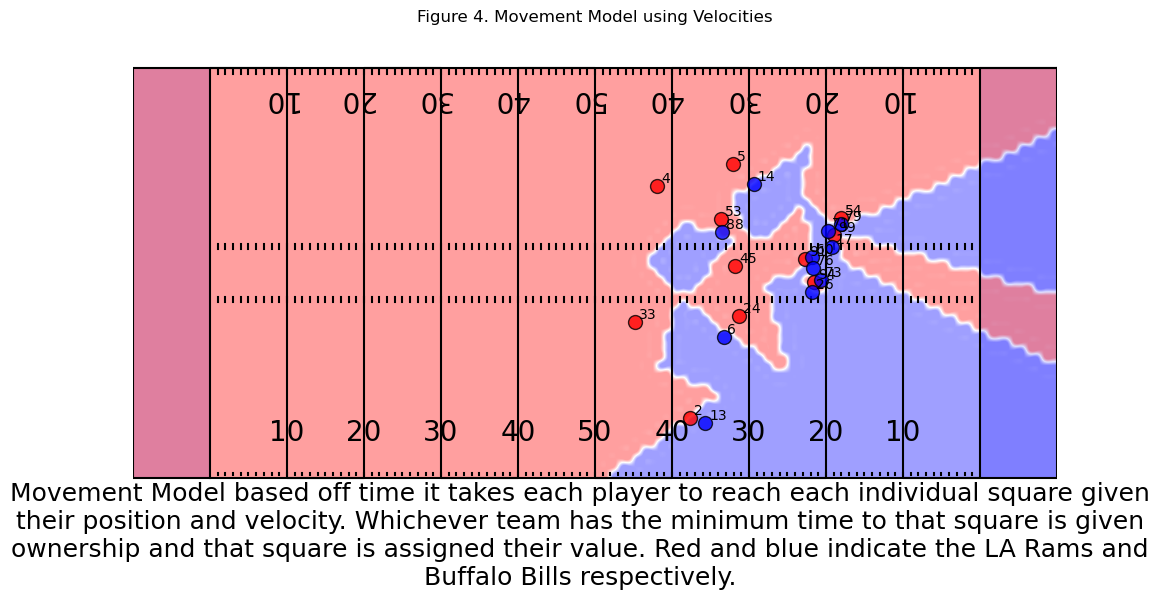

In [25]:
plot_pitch_control(PPCFa,defending_players,frame_of_interest,interpolation="spline36")
plt.title('Figure 4. Movement Model using Velocities')
caption = "Movement Model based off time it takes each player to reach each individual square given their position and velocity. Whichever team has the minimum time to that square is given ownership and that square is assigned their value. Red and blue indicate the LA Rams and Buffalo Bills respectively."
plt.figtext(0.5,0.01,caption,wrap = True, horizontalalignment = 'center', fontsize = '18')

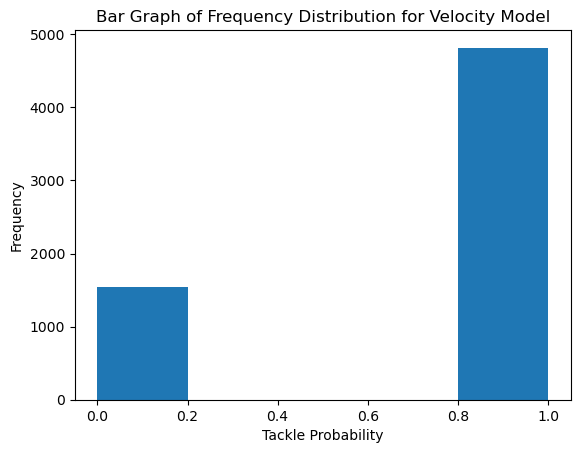

In [26]:
flattened_values = PPCFa.flatten()

# Define the bins (x-axis range)
bins = np.arange(0, 1.2, 0.2)

# Compute the histogram
hist, edges = np.histogram(flattened_values, bins=bins)

# Plotting the histogram as a bar graph
plt.bar(edges[:-1], hist, width=0.2, align='edge')

plt.xlabel('Tackle Probability')
plt.ylabel('Frequency')
plt.title('Bar Graph of Frequency Distribution for Velocity Model')
plt.show()

In [27]:
def calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, params):
    """ calculate_pitch_control_at_target
    
    Calculates the pitch control probability for the attacking and defending teams at a specified target position on the ball.
    
    Parameters
    -----------
        target_position: size 2 numpy array containing the (x,y) position of the position on the field to evaluate pitch control
        attacking_players: list of 'player' objects (see player class above) for the players on the attacking team (team in possession)
        defending_players: list of 'player' objects (see player class above) for the players on the defending team
        ball_start_pos: Current position of the ball (start position for a pass). If set to NaN, function will assume that the ball is already at the target position.
        params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        
    Returrns
    -----------
        PPCFatt: Pitch control probability for the attacking team
        PPCFdef: Pitch control probability for the defending team ( 1-PPCFatt-PPCFdef <  params['model_converge_tol'] )
    """
    # calculate ball travel time from start position to end position.
    if ball_start_pos is None or any(np.isnan(ball_start_pos)): # assume that ball is already at location
        ball_travel_time = 0.0 
    else:
        # ball travel time is distance to target position from current ball position divided assumed average ball speed
        ball_travel_time = np.linalg.norm( target_position - ball_start_pos )/params['average_ball_speed']
    
    # first get arrival time of 'nearest' attacking player (nearest also dependent on current velocity)
    tau_min_att = np.nanmin( [p.simple_time_to_intercept(target_position) for p in attacking_players] )
    tau_min_def = np.nanmin( [p.simple_time_to_intercept(target_position ) for p in defending_players] )
    
    # check whether we actually need to solve equation 3
    if tau_min_att-max(ball_travel_time,tau_min_def) >= params['time_to_control_def']:
        # if defending team can arrive significantly before attacking team, no need to solve pitch control model
        return 0., 1.
    elif tau_min_def-max(ball_travel_time,tau_min_att) >= params['time_to_control_att']:
        # if attacking team can arrive significantly before defending team, no need to solve pitch control model
        return 1., 0.
    else: 
        # solve pitch control model by integrating equation 3 in Spearman et al.
        # first remove any player that is far (in time) from the target location
        attacking_players = [p for p in attacking_players if p.time_to_intercept-tau_min_att < params['time_to_control_att'] ]
        defending_players = [p for p in defending_players if p.time_to_intercept-tau_min_def < params['time_to_control_def'] ]
        # set up integration arrays
        dT_array = np.arange(ball_travel_time-params['int_dt'],ball_travel_time+params['max_int_time'],params['int_dt']) 
        PPCFatt = np.zeros_like( dT_array )
        PPCFdef = np.zeros_like( dT_array )
        # integration equation 3 of Spearman 2018 until convergence or tolerance limit hit (see 'params')
        ptot = 0.0
        i = 1
        while 1-ptot>params['model_converge_tol'] and i<dT_array.size: 
            T = dT_array[i]
            for player in attacking_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*player.probability_intercept_ball( T ) * player.lambda_att
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid attacking player probability (calculate_pitch_control_at_target)'
                player.PPCF += dPPCFdT*params['int_dt'] # total contribution from individual player
                PPCFatt[i] += player.PPCF # add to sum over players in the attacking team (remembering array element is zero at the start of each integration iteration)
            for player in defending_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*player.probability_intercept_ball( T ) * player.lambda_def
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid defending player probability (calculate_pitch_control_at_target)'
                player.PPCF += dPPCFdT*params['int_dt'] # total contribution from individual player
                PPCFdef[i] += player.PPCF # add to sum over players in the defending team
            ptot = PPCFdef[i]+PPCFatt[i] # total pitch control probability 
            i += 1
        if i>=dT_array.size:
            print("Integration failed to converge: %1.3f" % (ptot) )
        return PPCFatt[i-1], PPCFdef[i-1]

In [28]:
for i in range( len(ygrid) ):
    for j in range( len(xgrid) ):
        target_position = np.array( [xgrid[j], ygrid[i]] )
        value = random.uniform(0, 1)
        PPCFa[i,j],PPCFd[i,j] = calculate_pitch_control_at_target(target_position, attacking_players, defending_players, None,params)


Text(0.5, 0.01, 'Movement Model based off a cumulitive distribution of a logistic function in order to calculate the time it takes each player to reach each individual square given their position and velocity. Whichever team has the minimum time to that square is given ownership and that square is assigned their value. Red and blue indicate the LA Rams and Buffalo Bills respectively.')

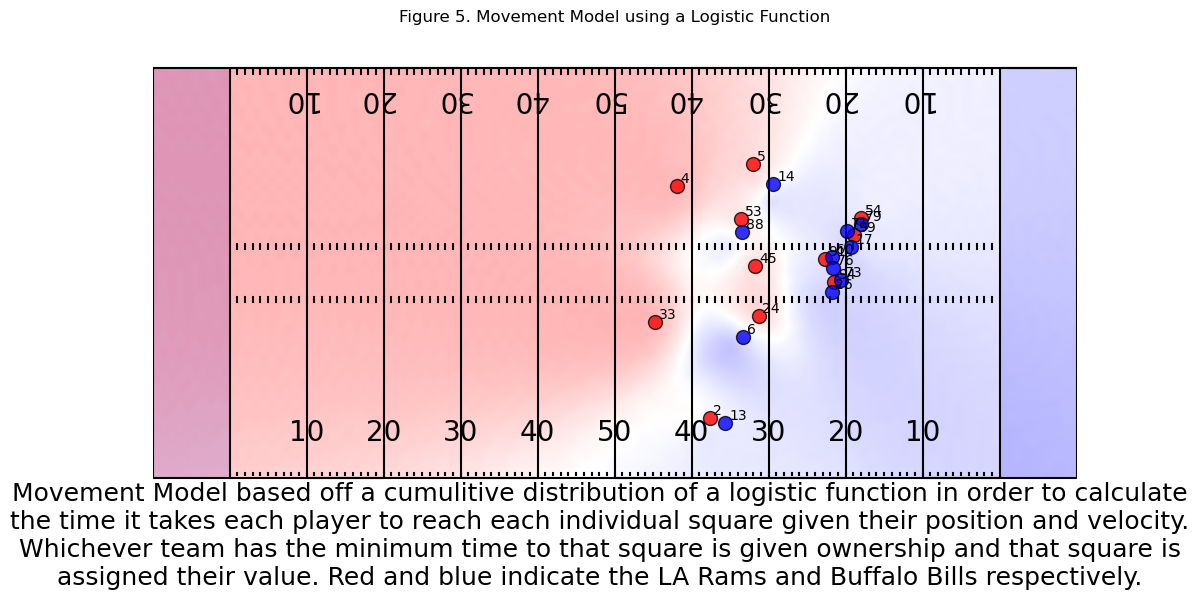

In [30]:
plot_pitch_control(PPCFa,0,frame_of_interest,interpolation="spline36")
plt.title('Figure 5. Movement Model using a Logistic Function')
caption = "Movement Model based off a cumulitive distribution of a logistic function in order to calculate the time it takes each player to reach each individual square given their position and velocity. Whichever team has the minimum time to that square is given ownership and that square is assigned their value. Red and blue indicate the LA Rams and Buffalo Bills respectively."
plt.figtext(0.5,0.01,caption,wrap = True, horizontalalignment = 'center', fontsize = '18')

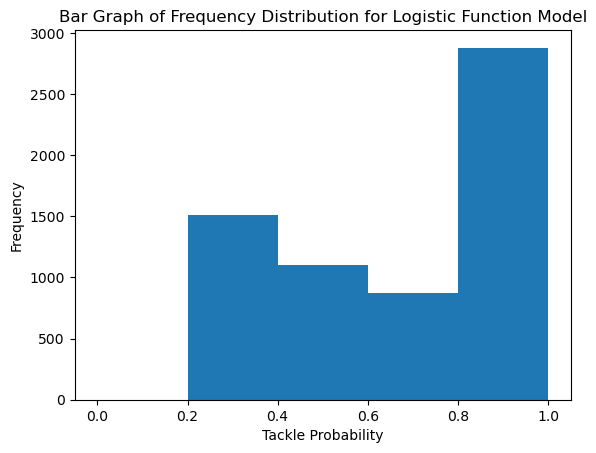

In [31]:
flattened_values = PPCFa.flatten()

# Define the bins (x-axis range)
bins = np.arange(0, 1.2, 0.2)

# Compute the histogram
hist, edges = np.histogram(flattened_values, bins=bins)

# Plotting the histogram as a bar graph
plt.bar(edges[:-1], hist, width=0.2, align='edge')

plt.xlabel('Tackle Probability')
plt.ylabel('Frequency')
plt.title('Bar Graph of Frequency Distribution for Logistic Function Model')
plt.show()

In [32]:
PPCFa

array([[0.77609836, 0.76555712, 0.77338436, ..., 0.29462005, 0.2976404 ,
        0.30035233],
       [0.77396486, 0.7820247 , 0.7717292 , ..., 0.29334011, 0.29618902,
        0.2987195 ],
       [0.78949967, 0.77949847, 0.78766516, ..., 0.30305237, 0.30552562,
        0.30772765],
       ...,
       [0.88689961, 0.87413431, 0.8839709 , ..., 0.40982859, 0.40817624,
        0.41988147],
       [0.86853996, 0.87869792, 0.88792527, ..., 0.41657038, 0.41553064,
        0.4141193 ],
       [0.87288069, 0.88245238, 0.86879532, ..., 0.42212603, 0.42159177,
        0.42071543]])